In [161]:
from pymongo import MongoClient
import string
import json 
import pickle as pkl
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from collections import Counter
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from urllib3.util import parse_url
import re
import time
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import linear_kernel

%matplotlib inline

pd.set_option('display.mpl_style', 'default') # Make the graphs a bit prettier
plt.rcParams['figure.figsize'] = (15, 5)

In [111]:
import sys
sys.path.append('../db')
from mongo import MyMongo

## read in articles from mongo db, clean, merge, tfidf

In [3]:
def clean_articles(cur_articles, articles_cleaned):
    articles = list(cur_articles)
    print '%d articles found' % len(articles)
    counter = 0
    for a in articles:
    #for a in cur_articles:
        url = a['url']
        body_text = a['body_text']
        l = len(body_text)
        if l > articles_cleaned.get(url,[0])[0]:
            articles_cleaned[url] = [len(body_text),body_text]

In [4]:
my_mongo = MyMongo()

articles_cleaned = {}
print '%d unique articles ' % len(articles_cleaned)

cur_articles = my_mongo.get_article_body_text(testing=0)
clean_articles(cur_articles, articles_cleaned)
print '%d unique articles ' % len(articles_cleaned)

atds links
0 unique articles 
815 articles found
791 unique articles 


In [5]:
my_mongo_nytimes = MyMongo(dbname  = 'nytimes')
cur_articles = my_mongo_nytimes.get_article_body_text(testing=0)
clean_articles(cur_articles, articles_cleaned)
print '%d unique articles ' % len(articles_cleaned)

nytimes links
488 articles found
1267 unique articles 


In [6]:
df = pd.DataFrame([{'url':k,'body_text':v[1]} for k, v in articles_cleaned.items()])

In [7]:
df.head(3)

,body_text,url
0,"Data Science in Python Tutorial, free tutorial...",http://www.kdnuggets.com/2014/01/top-tweets-ja...
1,A list of 150 Most Influential People on Twitt...,http://www.kdnuggets.com/2015/05/greycampus-15...
2,SAN FRANCISCO — When bankers of the future de...,http://www.nytimes.com/2015/01/19/technology/b...


In [297]:

article_dict =  MyMongo().get_article_attri()
article_dict2 =  MyMongo(dbname  = 'nytimes').get_article_attri()
article_dict_all = dict(article_dict, **article_dict2)

atds links
nytimes links


In [303]:
print article_dict2.items()[0][1].encode('ascii', 'ignore')
print article_dict2.items()[0][1].encode('utf8', 'ignore')

Creditworthy? Lets Consider Capitalization
Creditworthy? Let’s Consider Capitalization


In [144]:
print df2.shape
print pd.value_counts(df2['uri'])[:8]
print 1.0 *pd.value_counts(df2['uri'])[:8].sum()/df2.shape[0]
print df2.uri.nunique()

(1231, 6)
www.kdnuggets.com         357
www.nytimes.com           329
bits.blogs.nytimes.com    104
fivethirtyeight.com        56
www.youtube.com            13
dealbook.nytimes.com       11
medium.com                 10
cloudacademy.com           10
dtype: int64
0.72298943948
234


In [128]:
url = 'http://example.com/random/folder/path.html'
print parse_url(url)


http://example.com/random/folder/path.html


In [134]:
parse_url('http://google.com/mail/').host

#Url(scheme='http', host='google.com', port=None, path='/')

'google.com'

In [172]:
df2['uri'] = df2['url'].map(lambda x: parse_url(x).host)
#df2.head(2)
pd.value_counts(df2['uri'])[:10]



/Users/joyceduan/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


www.kdnuggets.com         357
www.nytimes.com           329
bits.blogs.nytimes.com    104
fivethirtyeight.com        56
www.youtube.com            13
dealbook.nytimes.com       11
medium.com                 10
cloudacademy.com           10
github.com                 10
radar.oreilly.com           8
dtype: int64

In [8]:
from sklearn.decomposition import NMF
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [9]:
def tokenize(doc):
        '''
        Tokenize and stem/lemmatize the document.
            - INPUT: string
            - OUTPUT: list of strings

        '''
        snowball = SnowballStemmer('english')
        #print type(doc), type([snowball.stem(word) for word in word_tokenize(doc.lower())])
        #print len(doc), len([snowball.stem(word) for word in word_tokenize(doc.lower())])
        words = []
        for word in word_tokenize(doc.strip().lower()):
            try:
                # .decode('utf-8'
                t = word.encode('ascii', 'ignore')
                words.append(t)                
            except:
                 t = ''
        return [snowball.stem(word) for word in words]

def fit_tfidf(docs):
    '''
        - INPUT: X. list of string
        - OUPUT: list of list
    '''
    tokenized_articles = [tokenize(doc) for doc in docs]
    vectorizer = TfidfVectorizer(stop_words = 'english', max_features = 5000)
    documents = [' '.join(article) for article in tokenized_articles]
    vectorizer =  vectorizer.fit(documents)

    vectors_doc = vectorizer.transform(documents).todense()
    return vectorizer, vectors_doc, tokenized_articles

def transform_tfidf(vectorizer, docs):
    '''
    transform text to tfidf
        - INPUT:  list of string :  (string / text)
        - OUTOUT: list of float
    '''
    tokenized_articles = [tokenize(doc) for doc in docs]
    documents = [' '.join(article) for article in tokenized_articles]
    return vectorizer.transform(documents).todense(), tokenized_articles


In [10]:
def run_nmf(X, n_topics=20, **kwargs):
    '''
    NMF on the TF-IDF feature matrix to create a topic model.
        - INPUT:  
            X: 2d numpy array 
            n_topics: int 
            **kwargs: NMF parameters
        - OUTPUT: 
             W (Article-Topic matrix):2d numpy array
            H (Topic-Term matrix): 2d numpy array 
    '''
    nmf = NMF(n_components=n_topics, **kwargs)
    W = nmf.fit_transform(X)
    H = nmf.components_
    return W, H, nmf

In [27]:
txt_list = df.body_text
vectorizer, vectorized_X, tokenized_articles = fit_tfidf(txt_list)
df['len'] = [len(t) for t in tokenized_articles]
df['tokens'] = tokenized_articles

## Run NMF for topic modeling

In [12]:
#vectorized_X, tokenized_articles = transform_tfidf(vectorizer, txt_list)

In [42]:
cond = df['len'] >= 50  # only keeps articles with at least 50 words
df2 = df[cond]
irows = [i for i in xrange(vectorized_X.shape[0]) if cond[i]]
X2 =vectorized_X[np.ix_(irows)]
url_list2 = df2['url']

In [352]:
idx_df = list(df2.index)

In [304]:
df2['title'] = df2['url'].map(lambda x: article_dict_all.get(x,'Unknown'))

/Users/joyceduan/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [45]:
W, H = run_nmf(X2 )

In [75]:
print 'w ', W.shape, 'h', H.shape

 w  (1231, 20) h (20, 5000)


In [83]:
W_t = (W.T)
print W.shape, W_t.shape
print type(W_t)
print len(W_t[0,]), W_t[0]

(1231, 20) (20, 1231)
<type 'numpy.ndarray'>
1231 [ 0.01091977  0.07957878  0.01727397 ..., -0.          0.02511491
  0.05005001]


In [114]:
W_t = W.T
n_top_articles = 5
n_top_terms = 5
for topic_idx, article_w in enumerate(W_t):
    print("Topic #%d:" % topic_idx)
    
    #    for i, topic in enumerate(topic_terms):
    terms = topic_terms[topic_idx]
    l = sorted(terms.items(), key=lambda x: x[1])[::-1]
    txt_list = []
    for item in l[:n_top_terms]:
        txt_list.append('%s (%.2f)' % (item[0], item[1]))
    print 'top terms: ',', '.join(txt_list)
    print '-------'
    #print article_w.shape
    idx_article_topn = article_w.argsort()[:-n_top_articles - 1:-1]
    for i, idx in enumerate(idx_article_topn):
        url = df2.iloc[idx]['url']
        print '**** ', i,'. (%.2f))'% article_w[idx], article_dict_all.get(url,'')
        print url
        print df2.iloc[idx]['body_text'][:400]
        print 
    print 

Topic #0:
top terms:  data (27.02), big (8.30), scienc (7.20), scientist (5.82), busi (2.35)
-------
****  0 . (0.23)) Comments on “Why your company should NOT use Big Data”
http://www.kdnuggets.com/2014/02/comments-why-your-company-should-not-use-big-data.html
comments
By Gregory Piatetsky, Feb 10, 2014.
The guest post in KDnuggets by Edward Nevraumont, Viewpoint: Why your company should NOT use "Big Data" ,  has generated quite a lot of heat and some light, and here are  selected comments from LinkedIn (mainly from  Advanced Business Analytics, Data Mining and Predictive Modeling group).
In my opinion, while Big Data is extremely useful for large compa

****  1 . (0.23)) The Data Science Handbook: Interviews with 25 Data Scientists 
http://www.thedatasciencehandbook.com/
Conversations With 25 Data Scientists
 
What's Inside The Book?
The Data Science Handbook is a compilation of in-depth interviews with 25 remarkable data scientists, where they share their insights, stories, and advi

#### get the most relevant topic for each article 

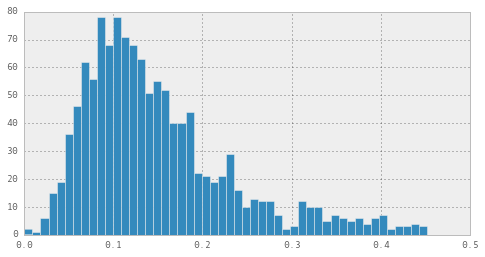

In [239]:
best_topics_for_articles = []
for i_article, topic_w in enumerate(W):
    i_best_topic = np.argmax(topic_w)
    best_topics_for_articles.append([i_best_topic, topic_w[i_best_topic]])
best_topics_for_articles = np.array(best_topics_for_articles)
fig = plt.figure(figsize=(8,4))
plt.hist(best_topics_for_articles[:,1], bins =50)
plt.show()

In [244]:
cond_topic = best_topics_for_articles[:,1] > 0.33
pd.value_counts(best_topics_for_articles[cond_topic,0])

1     35
11     6
8      6
18     5
13     4
19     4
12     1
9      1
2      1
16     1
dtype: int64

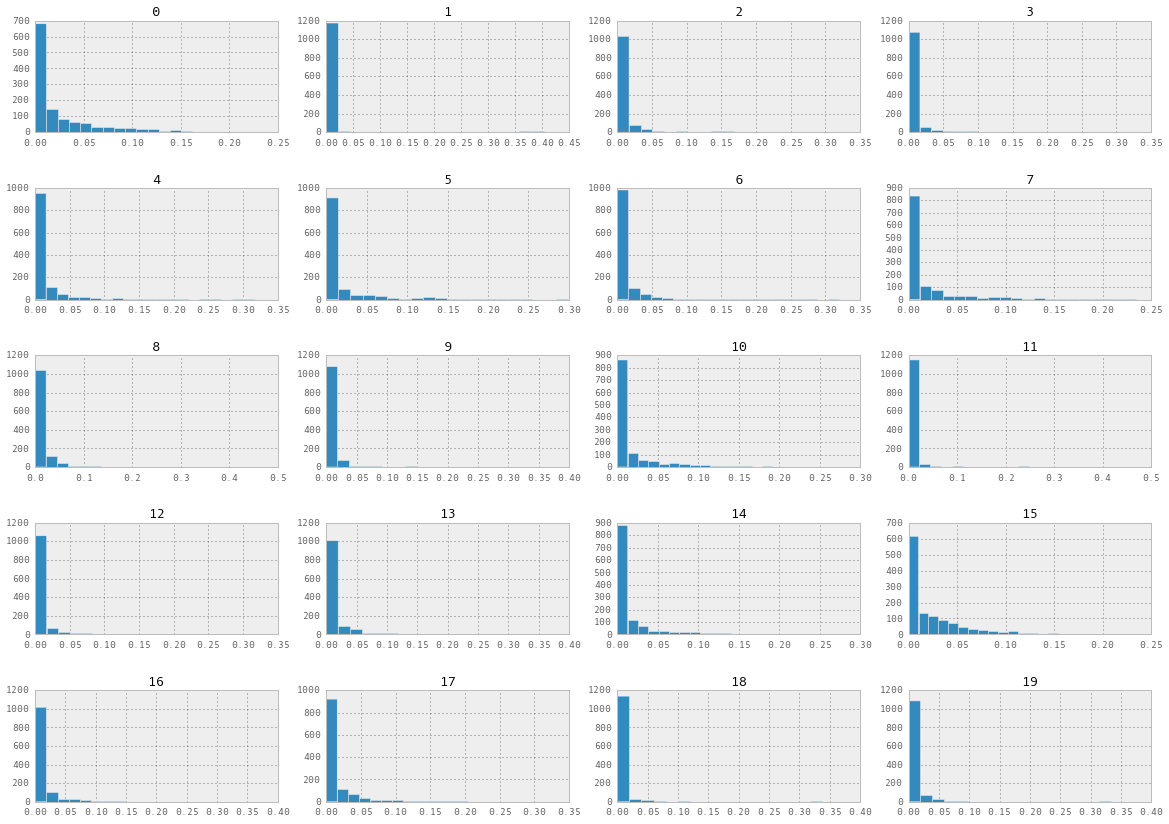

In [105]:
n = W_t.shape[0]
ncols = 4
nrows = n // ncols + ( (n % ncols)>0 )
fig, ax = plt.subplots(nrows, ncols, figsize = (20,14))
axs = ax.flatten()
for i, article_w in enumerate(W_t):
    axs[i].hist(article_w, bins =20)
    axs[i].set_title(str(i))
plt.show()
    

[(100, 0.45178600550299125), (99, 0.20456999563058162), (98, 0.15053536969806591), (97, 0.11960559827637235), (96, 0.099365382677294223), (95, 0.084573431443616967), (90, 0.043308020902871051), (85, 0.026134143808129333), (80, 0.01680845073482452), (75, 0.011096468706582386), (50, -0.0)]


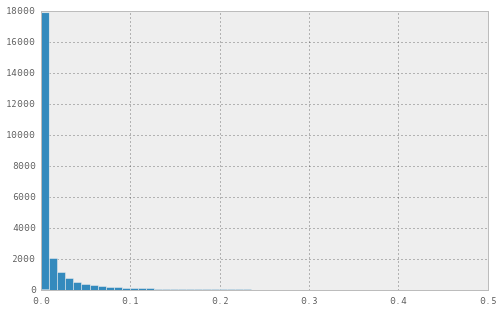

In [120]:
p =  [100,99,98,97,96,95,90,85,80,75,50]
print zip(p, np.percentile(W_t.flatten(), p))
fig = plt.figure(figsize=(8,5))
plt.hist(W_t.flatten(), bins=50)
plt.show()

In [72]:
def get_top_topics_terms(vectorizer, H, k_top_words=50):
    '''
    get the k_top_words for each topic
        - INPUT:  
        - OUTPUT: dict - topics_dicts (most important terms for each topic)
    '''
    topic_terms = []
    n_topics = H.shape[0]

    for i in xrange(n_topics):
        k, v = zip(*sorted(zip(vectorizer.get_feature_names(), H[i]),
                           key=lambda x: x[1])[:-k_top_words:-1])
        val_arr = np.array(v)
        norms = val_arr / np.sum(val_arr)
        topic_terms.append(dict(zip(k, norms * 100)))
    return topic_terms


def print_topic_terms(topic_terms):
    for i, topic in enumerate(topic_terms):
        l = sorted(topic.items(), key=lambda x: x[1])[::-1]
        print "Topic #" + str(i)
        txt_list = []
        for item in l:
            txt_list.append('%s (%.2f)' % (item[0], item[1]))
        print '.'.join(txt_list)

## article recommendations based on slack chats

In [149]:
! ls ../../data

slack.txt


In [158]:
data_file = '../../data/slack.txt'
with open(data_file, 'r') as in_fh:
    data = in_fh.read()

In [ ]:
data2 = data.decode(('utf8'))

In [163]:
#data2 = data2.encode('ascii', 'ignore')
test_X, tokenized_slacks = transform_tfidf(vectorizer, [data2])
test_X = test_X.getA().flatten()

In [223]:
stop_words_fix = [ u'text/html', 'pm', 'http' 'io','com', 'github', 'www' ,'config', 'html', 'js' ,'https', 'join', 'repo','chris',u'http']
cleaned_slack = []
for w in tokenized_slacks[0]:
    if  re.search('[a-zA-Z]',w) and '//' not in w and 'sf_ds' not in w:
        if w not in stop_words_fix:
            cleaned_slack.append(w)
print cleaned_slack

[u'1034hmanu', u'vanconcelo', u'also', u'tammyl', 'am', u'tammyl', u'remind', u'tomorrow', u'mentor', u'mixer', u'69pm', u'new', u'event', u'this', u'wednesday', u'guest', u'speaker', u'ken', u'dooley', 'a', u'past', u'student', 'to', u'talk', u'about', u'the', u'project', u'you', u'can', u'view', u'his', u'project', 'at', u'tast.io', u'and', u'also', u'his', u'kendooley/tast.io', u'contribut', 'to', u'tast.io', u'develop', 'by', u'creat', 'an', u'account', 'on', u'tammyl', u'new', u'event', u'this', u'wednesday', u'lunchtim', u'talk', u'about', u'partner', u'project', u'yelp', u'data', u'scienc', u'contest', u'predict', u'restaur', u'health', u'score', u'giovanna', u'thron', u'also', u'today', 'at', u'6pm', u'were', u'have', 'a', u'happi', u'hour', u'for', u'the', u'new', 'ds', u'student', 'in', u'the', u'speakeasi', u'come', u'meet', u'them', u'they', u'are', u'like', u'you', u'week', u'ago', u'today', u'6:00pm', u'happi', u'hour', u'speakeasi', u'basement', u'tammyl', u'plea', u'use

In [224]:
cleaned_slack = ' '.join(cleaned_slack)

In [225]:
test_X2, tokenized_slacks2 = transform_tfidf(vectorizer, [cleaned_slack])
test_X2 = test_X2.getA().flatten()

#### most common words in 06-04 slack

In [229]:
top_n = 100
desc_feature_indexes = list(np.argsort(test_X2)[::-1])
#print test_X2[desc_feature_indexes[:top_n]]
features = vectorizer.get_feature_names()
txt_list = []
for i in desc_feature_indexes[:top_n] :
    txt_list.append('%s (%.2f)' % (features[i], test_X2[i]))
print ', '.join(txt_list)

3d (0.52), js (0.19), d3 (0.19), tast (0.17), visual (0.17), plea (0.16), io (0.15), happi (0.15), today (0.13), anyon (0.12), set (0.12), data (0.12), jonathan (0.12), mentor (0.11), scott (0.11), project (0.11), file (0.11), workshop (0.11), photo (0.10), met (0.10), list (0.09), monday (0.09), wednesday (0.09), giant (0.09), public (0.08), separ (0.08), em (0.07), page (0.07), hour (0.07), new (0.07), python (0.07), event (0.07), tonight (0.07), ds (0.07), class (0.07), os (0.07), just (0.07), student (0.07), suck (0.07), yelp (0.07), talk (0.07), scienc (0.07), sf (0.07), jon (0.06), access (0.06), rid (0.06), type (0.06), greg (0.06), civic (0.06), drone (0.06), jose (0.06), s3 (0.06), mac (0.06), guest (0.06), week (0.06), tomorrow (0.06), sourc (0.06), camera (0.06), airlin (0.06), linux (0.06), youd (0.06), saturday (0.05), csv (0.05), manner (0.05), restaur (0.05), youtub (0.05), remind (0.05), fee (0.05), bunch (0.05), contest (0.05), tri (0.05), think (0.05), buff (0.05), in

#### most relevant articles

In [231]:
cosine_similarities = linear_kernel(vectorized_X, test_X).flatten()

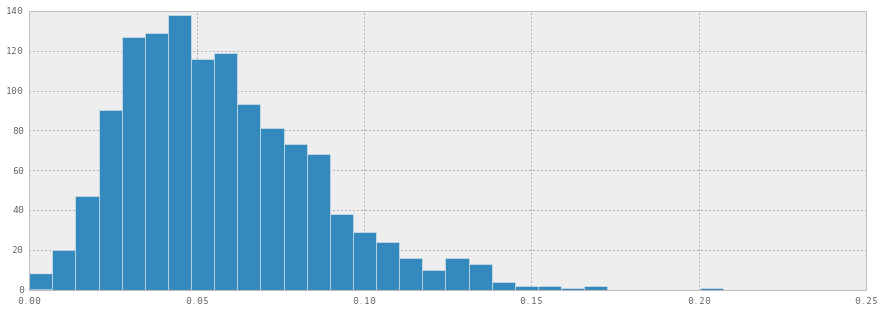

In [232]:
plt.hist(cosine_similarities,bins=30)
plt.show()

In [234]:
desc_sim_indexes = np.argsort(cosine_similarities)[::-1]
cosine_similarities[desc_sim_indexes[:5]]
for i in desc_sim_indexes[:5]:
    url = df2.iloc[i].url
    print cosine_similarities[i], '***'+article_dict_all.get(url,' ')+'***'
    print url
    print df2.iloc[i].body_text[:300]
    print 

0.207216752819 ***Practical Text Analysis using Deep Learning ***
http://blog.dato.com/practical-text-analysis-using-deep-learning
Practical Text Analysis using Deep Learning
Posted by Michael Fire on May 1, 2015 7:00:00 AM
Topics: Machine Learning Models , Text Classification , Data Science
Deep Learning has become a household buzzword these days, and I have not stopped hearing about it. In the beginning, I thought it was anot

0.168527292086 ***Why Do Ben 10s Divorce Sugar Mamas? ***
http://www.iafrikan.com/2015/05/25/ben10-sugar-mama-south-africa-marriage-data/
Why Do Ben 10s Divorce Sugar Mamas?
25 May 2015
Article Image
South Africa is one of the few countries on the continent that publishes marriage and divorce data. Even better, Statistics South Africa (StatsSA) makes available individual (couple) information about marriages and divorces. This allows u

0.166703730939 *** ***
http://www.nytimes.com/2014/11/08/us/politics/republicans-beat-democrats-at-their-own-ground-game.html
T

### recommend articles based on known user rating

In [160]:
tokenized_slacks[0][:10]

['\x1b',
 '[',
 '?',
 u'1034hmanu',
 u'vanconcelo',
 u'join',
 '#',
 u'sf_ds_april_2015',
 '.',
 u'also']

In [ ]:
n_topics = 20
#n_top_words = 5
t0 = time.time()
print("Fitting the NMF model with") # n_samples=%d and n_features=%d..."
    #  % ())
nmf = NMF(n_components=n_topics, random_state=1).fit(X2)

In [68]:
print("done in %0.3fs." % (time.time() - t0))
n_top_words = 20
feature_names = vectorizer.get_feature_names()

for topic_idx, topic in enumerate(nmf.components_):
    print("Topic #%d:" % topic_idx)
    print(" ".join([feature_names[i]
                    for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print

done in 149.048s.
Topic #0:
data big scienc scientist busi insight engin analysi tool team visual work open program collect softwar databas skill 2014 need

Topic #1:
ly buff bigdata datasci tweet bit kdnugget shrd data analyt rstat scientist free twitter python 10 popular bigdataco scienc retweet

Topic #2:
privaci said law inform consum collect compani mr data protect obama person secur report agenc govern use feder podesta hous

Topic #3:
student school colleg educ teacher graduat univers program degre parent cours teach class year mr skill classroom mooc children job

Topic #4:
model predict dataset train use data bigml machin api regress featur servic aw evalu learn classif creat build tree amazon

Topic #5:
analyt busi predict custom confer industri 2014 manag big paw profession text leader advanc session webinar world practition speaker expert

Topic #6:
percent republican democrat poll voter digit year vote million campaign elect signific news polit rent newslett 2015 parti sur

In [73]:
topic_terms = get_top_topics_terms(vectorizer, H)
print_topic_terms(topic_terms)

Topic #0
data (27.02).big (8.30).scienc (7.20).scientist (5.82).busi (2.35).insight (2.19).engin (1.98).analysi (1.86).tool (1.65).team (1.52).visual (1.47).work (1.47).open (1.45).program (1.39).collect (1.32).softwar (1.28).databas (1.23).skill (1.23).2014 (1.20).need (1.19).role (1.18).prepar (1.14).analyz (1.14).field (1.11).project (1.10).use (1.05).access (1.03).inform (0.98).sourc (0.96).focus (0.96).import (0.92).challeng (0.92).strata (0.90).start (0.90).domain (0.88).discoveri (0.87).gregori (0.87).question (0.87).excel (0.86).compani (0.86).build (0.85).technic (0.84).key (0.84).present (0.84).product (0.83).knowledg (0.80).decis (0.80).great (0.79).techniqu (0.79)
Topic #1
ly (21.46).buff (17.88).bigdata (5.88).datasci (3.51).tweet (3.27).bit (2.97).kdnugget (2.89).shrd (2.50).data (2.48).analyt (2.20).rstat (1.95).scientist (1.61).free (1.57).twitter (1.55).python (1.42).10 (1.41).popular (1.27).bigdataco (1.23).scienc (1.20).retweet (1.15).vs (1.10).favorit (1.00).learn (

In [35]:
 t[np.ix_(irows, icols)]
X2 = vectorized_X[list(cond)]
len(vectorized_X), len(X2)

numpy.matrixlib.defmatrix.matrix

In [14]:
df['len'].describe()

count     1267.000000
mean       933.573796
std       1220.078270
min          8.000000
25%        311.500000
50%        686.000000
75%       1170.500000
max      20075.000000
Name: len, dtype: float64

In [19]:
df['len_capped'] = df['len'].map(lambda x: x if x < 5000 else 5000 )

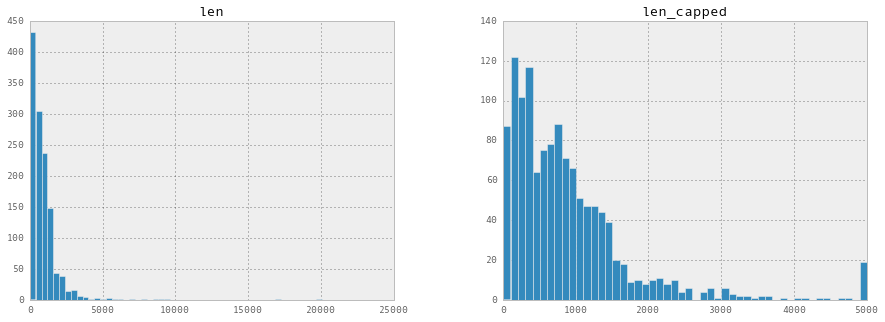

In [23]:
df[['len','len_capped']].hist( bins = 50)
plt.show()

In [26]:
cuts_min = [30,50,100]
for cut in cuts_min:
    print cut, df[df['len']<cut].shape
cuts_max = [4000,5000]
for cut in cuts_max:
    print cut, df[df['len']>cut].shape

30 (14, 5)
50 (36, 5)
100 (83, 5)
4000 (25, 5)
5000 (18, 5)


In [ ]:
len_min = 50


In [15]:
'''
regex = re.compile('<.+?>|[^a-zA-Z]')
porter = PorterStemmer()
stop_words_lst = stop_words = stopwords.words('english')

def tokenize(text):
    clean_txt = regex.sub(' ', text) #remove any characters that are not english characters.
    clean_txt = clean_txt.lower()
    #  punct_removed = ''.join([letter for letter in word if not letter in PUNCTUATION])???
    stemmed =  [porter.stem(w.strip(string.punctuation)) for w in re.split(' +', clean_txt) \
            if w not in stop_words_lst]
    return [w for w in stemmed if w != '']  
'''

"\nregex = re.compile('<.+?>|[^a-zA-Z]')\nporter = PorterStemmer()\nstop_words_lst = stop_words = stopwords.words('english')\n\ndef tokenize(text):\n    clean_txt = regex.sub(' ', text) #remove any characters that are not english characters.\n    clean_txt = clean_txt.lower()\n    #  punct_removed = ''.join([letter for letter in word if not letter in PUNCTUATION])???\n    stemmed =  [porter.stem(w.strip(string.punctuation)) for w in re.split(' +', clean_txt)             if w not in stop_words_lst]\n    return [w for w in stemmed if w != '']  \n"

In [293]:
df2.head()

,body_text,url,len,tokens,len_capped,uri,title
0,"Data Science in Python Tutorial, free tutorial...",http://www.kdnuggets.com/2014/01/top-tweets-ja...,347,"[data, scienc, in, python, tutori, ,, free, tu...",347,www.kdnuggets.com,"Top KDnuggets tweets, Jan 13-14: Data Science ..."
1,A list of 150 Most Influential People on Twitt...,http://www.kdnuggets.com/2015/05/greycampus-15...,857,"[a, list, of, 150, most, influenti, peopl, on,...",857,www.kdnuggets.com,150 Most\nInfluential People in Big Data & Hadoop
2,SAN FRANCISCO — When bankers of the future de...,http://www.nytimes.com/2015/01/19/technology/b...,1409,"[san, francisco, , when, banker, of, the, futu...",1409,www.nytimes.com,Unknown
3,By Sameer Manek .\nI've noticed people frequen...,http://www.kdnuggets.com/2015/05/surprising-ra...,316,"[by, sameer, manek, ., i, ve, notic, peopl, fr...",316,www.kdnuggets.com,Surprising Random Correlations
4,"On Wednesday morning, during Google’s annual m...",http://www.nytimes.com/2015/06/06/opinion/joe-...,924,"[on, wednesday, morn, ,, dure, googl, annual, ...",924,www.nytimes.com,Unknown


In [254]:
url = 
df2[df2.url == url]

,body_text,url,len,tokens,len_capped,uri,title
183,HARVARD BUSINESS REVIEW calls data science “th...,http://www.nytimes.com/2013/04/14/education/ed...,1193,"[harvard, busi, review, call, data, scienc, th...",1193,www.nytimes.com,KDnuggets Exclusive: Interview with Quentin Cl...


In [257]:
good_urls = ['http://www.bloomberg.com/news/articles/2015-06-04/help-wanted-black-belts-in-data', 
        'http://bits.blogs.nytimes.com/2015/04/28/less-noise-but-more-money-in-data-science/'
       , 'http://bits.blogs.nytimes.com/2013/06/19/sizing-up-big-data-broadening-beyond-the-internet/'
       ]
meh_urls = ['http://bits.blogs.nytimes.com/2013/04/11/education-life-teaching-the-techies/' # too short, no content
, 'http://www.nytimes.com/2013/04/14/education/edlife/universities-offer-courses-in-a-hot-new-field-data-science.html'  
]

In [363]:
def get_rating(good_urls, meh_urls, df2):
    '''
    generate rating_content from list of good and meh urls
        -OUTPUT: rating_content list of list  (i_article, rating_score)
    '''
    score_good = 4
    score_meh = 1
    rating_content = []
    cond1 = df2.url.isin(good_urls)
    #print type(cond1)
    #print cond1[:5]
    #index_good = list(df2[cond1].index)
    ilocs_good = [i for i in xrange(df2.shape[0]) if cond1.iloc[i]]
    #print i_rows_good
    
    cond2 = df2.url.isin(meh_urls)
    #index_meh = list(df2[cond2].index)
    #print index_meh
    ilocs_meh = [i for i in xrange(df2.shape[0]) if cond2.iloc[i]]
    
    for i in ilocs_good:
        rating_content.append((i,score_good))
    for i in ilocs_meh:
         rating_content.append((i,score_meh))
    return np.array(rating_content)
print get_rating(good_urls, meh_urls, df2)    

[[220   4]
 [727   4]
 [901   4]
 [180   1]
 [851   1]]


In [362]:
print df2.iloc[220]['url']

http://bits.blogs.nytimes.com/2013/06/19/sizing-up-big-data-broadening-beyond-the-internet/


In [279]:
sys.path.append('../recommender')
from ItemItem import *

In [392]:
rating_content = get_rating(good_urls, meh_urls, df2)  
rating_vec = np.zeros(df2.shape[0])
for row in rating_content:
    rating_vec[row[0]] =  row[1]
print rating_content
print [i for i in xrange(len(rating_vec)) if rating_vec[i]>0]

[[220   4]
 [727   4]
 [901   4]
 [180   1]
 [851   1]]
[180, 220, 727, 851, 901]


In [263]:
print X2.shape, df2.shape

(1231, 5000) (1231, 7)


In [339]:
def format_article(i, df2):
    n_chars = 500
    s = '***** %s ****' % df2.iloc[i]['title']
    s = s + '\n' + df2.iloc[i]['url']
    s = s + '\n\n' + df2.iloc[i]['body_text'][:n_chars]
    return s

def print_articles(idx, df2, scores):
    '''
    print list of articles and associated scores
    '''
    for i in idx:
        str_article = format_article(i, df2)
        print '%d %.2f %s ' % (i, scores[i], str_article)
        print 

def print_articles_2scores(idx, df2, sim, rating):
    '''
    print list of articles and associated scores
    '''
    for i in idx:
        str_article = format_article(i, df2)
        print '%d sim: %.2f rating: %.2f %s ' % (i, sim[i],rating[i], str_article)
        print 

        

In [268]:
my_rec_engine = ItemItemRec(neighborhood_size=75)
my_rec_engine.fit_item_features(X2)

In [393]:
rating_predict, relevant_items_all = my_rec_engine.pred_one_user_from_rating (rating_content, report_run_time=False)
    

In [ ]:
rating_weighted = []
for i_article in xrange(len(rating_predict)):
    sim_vec = [my_rec_engine.item_sim_mat[i_article,j] 
               for j in  relevant_items_all[i_article]] 
    sim_max = np.max(sim_vec)
    rating_weighted.append(rating_predict[i_article] * sim_avg)
rating_weighted = np.array(rating_weighted)
rating_weighted[np.argsort(-1.0*rating_weighted)[:5]]

In [394]:
for i_article in np.argsort(-1.0*rating_predict)[:3]:
    #i_article = 602
    relevant_items = relevant_items_all[i_article]
    #ratings_sim = [rating_dict[i] for i in relevant_items]
    sim_vec = my_rec_engine.item_sim_mat[i_article,:].flatten()#, relevant_items] 
    print 'recommend:'
    print_articles([i_article],df2, rating_predict)
    print '---- based on:'
    print_articles_2scores(relevant_items, df2, sim_vec, rating_vec)

recommend:
652 4.00 ***** Nubank Raises $30 Million to Challenge Banking in Brazil ****
http://www.nytimes.com/2015/06/03/business/dealbook/nubank-raises-30-million-to-challenge-banking-in-brazil.html

RIO DE JANEIRO — Nubank, the financial technology start-up founded by a former partner at Sequoia Capital, said on Tuesday that it had raised $30 million in a new funding round led by Tiger Global Management. Sequoia and another original backer, Kaszek Ventures, which is based in Buenos Aires, also joined in the round, which closed about two weeks ago, the company’s founder and chief executive, David Velez, said in an interview. QED Investors, which first invested in Nubank last year at the end  

---- based on:
727 sim: 0.13 rating: 4.00 ***** Help Wanted: Black Belts in Data  ****
http://www.bloomberg.com/news/articles/2015-06-04/help-wanted-black-belts-in-data

Share on LinkedIn Share on Reddit Share on Google+ E-mail
A new species of techie is in demand these days—not only in Silicon

In [397]:
pkl.dump(df_recom,open('df_recom.pkl','w'))
pkl.dump(relevant_all,open('relevant_all.pkl','w'))


In [380]:
with open('relevant_all.pkl','r') as f:
    test = pkl.load(f)
type(test)

list

In [390]:
df = test[0]
print type(df)
for index, row in df.iterrows():
    print row

<class 'pandas.core.frame.DataFrame'>
body_text    Machine Learning in Parallel with SVM, GLM; Go...
i                                                          754
rating                                                       4
sim                                                  0.6877297
title        Top KDnuggets tweets, Mar 21-23: Machine Learn...
url          http://www.kdnuggets.com/2014/03/top-tweets-ma...
Name: 0, dtype: object


In [396]:
recommed_articles = []
relevant_all = []

for i_article in np.argsort(-1.0*rating_predict)[:3]:
    r= {}
    #i_article = 602
    relevant_items = relevant_items_all[i_article]
    sim_vec = my_rec_engine.item_sim_mat[i_article,:].flatten()#, relevant_items] 
    r['score'] = rating_predict[i_article]
    r['title'] = df2.iloc[i_article]['title']
    r['body_text']=df2.iloc[i_article]['body_text']
    r['url'] = df2.iloc[i_article]['url']

    recommed_articles.append(r)
    
    relevent = []
    for i_revelent in relevant_items:
        rele = {}
        rele['rating'] =  rating_vec[i_revelent]
        rele['sim'] = sim_vec[i_revelent]
        rele['title'] = df2.iloc[i_revelent]['title']
        rele['body_text']=df2.iloc[i_revelent]['body_text']
        rele['url'] = df2.iloc[i_revelent]['url']
        rele['i'] = i_revelent
        relevent.append(rele)
    df_relevant = pd.DataFrame(relevent)
    relevant_all.append(df_relevant)
    
df_recom = pd.DataFrame(recommed_articles)

print df_recom.head()
print '-------'
print relevant_all

                                           body_text  score  \
0  RIO DE JANEIRO — Nubank, the financial technol...      4   
1  Alternative consumer lenders tend to fit into ...      4   
2  There was a lot of hype surrounding the first ...      4   

                                               title  \
0  Nubank Raises $30 Million to Challenge Banking...   
1                         Social ‘Trust’ and Lending   
2                                  A Look at Round 1   

                                                 url  
0  http://www.nytimes.com/2015/06/03/business/dea...  
1  http://bits.blogs.nytimes.com/2015/04/07/measu...  
2  http://sports.blogs.nytimes.com/2014/05/08/hig...  
-------
[                                           body_text    i  rating       sim  \
0  Share on LinkedIn Share on Reddit Share on Goo...  727       4  0.129526   
1  April 28, 2015 9:30 am\nApril 28, 2015 9:30 am...  901       4  0.159006   

                                               title  \

In [307]:
n_top = 10
idx_top = np.argsort(-1.0*rating_predict)[:n_top]
print_articles(idx_top, df2, rating_predict)

0 4.00 ***** Top KDnuggets tweets, Jan 13-14: Data Science in Python, Free Tutorial; How Netflix Got Analytics Wrong, Then Right ****
http://www.kdnuggets.com/2014/01/top-tweets-jan13-14.html

Data Science in Python Tutorial, free tutorial; How Netflix Got Analytics Wrong, Then Right; Cartoon: Lets solve this problem by using #BigData none of us have any idea what to do with ; "Data Scientist" fever in Japan is gone?
Most popular KDnuggets tweets
(see twitter.com/kdnuggets ) for Jan 13-14 were
 
How Netflix Got Analytics Wrong, Then Right - two entertaining and informative stories #NetflixPrize #BigData buff.ly/1fvckCN
Most Retweeted:
Cartoon: Let's solve this problem by using #BigDat 

602 4.00 ***** Letters ****
http://www.nytimes.com/2015/02/01/books/review/letters-among-the-disrupted.html

‘Among the Disrupted’ To the Editor: With friends like Leon Wieseltier (“Among the Disrupted,” Jan. 18), humanism doesn’t need enemies. The greatest weakness of humanism ­— painfully manifest in 

In [313]:
print sum(rating_predict>3.9999), 1.0 * sum(rating_predict>3.99)/len(rating_predict)

225 0.182778229082


In [311]:
len(rating_predict)

1231